# Imports

In [67]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import pickle
import numpy as np
import sys
sys.path.append("../..")
from utils.diverse import *
from utils.data_transformations import *
from utils.visualization_tools import *
from sklearn.utils import resample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
set_random_state(42)

In [69]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Load dataset

In [70]:
with open("../../../../main_experiment/sparse_data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
slow_wave_ids = list(dataset["sws"].keys())
print(len(slow_wave_ids))

3025


In [71]:
dataset["sws"][slow_wave_ids[0]].keys()

dict_keys(['file_id', 'gcamp_mean', 'gcamp_aligned', 'shape', 'gcamp_interpolated', 'hemo_aligned', 'hemo_interpolated', 'height', 'width', 'start', 'stop', 'correlation', 'nc_start', 'nc_stop', 'left_too_high', 'iso', 'gcamp_improved_interpolated', 'flow_components', 'mean_sources', 'mean_sinks'])

# Load data for features, select slow waves

In [72]:
def interpolate(y, n = 10):
    return interp1d(np.arange(len(y)), y)(np.linspace(0,len(y)-1, n))

In [73]:
# Get features
features = ["iso", "start", "stop", "width", "height", "gcamp_interpolated", "gcamp_mean", 
            "hemo_interpolated", "left_too_high", "correlation", "mean_sources", "mean_sinks"]
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features)

# Determine waves that shall be analyzed
where = corr < .3
where[height/width < 0.09] = False
where[left_too_high] = False
#where[height/width < 0.05] = False
print(str(np.sum(where)) + " samples selected")

## Get features for selected waves
# 1. Basic features
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features, where)

# 2. Direction of flow in time
flow_dir = [dataset["sws"][id]["flow_components"]["per_frame"]["left_hemisphere"] for id in slow_wave_ids]
flow_dir = [[interpolate(f[0], 128),interpolate(f[1], 128),interpolate(f[2], 128),interpolate(f[3], 128)] for f in flow_dir]
flow_dir = np.array(flow_dir)
flow_dir = flow_dir[where]
ud_in_time = flow_dir[:,0,:] - flow_dir[:,1,:]#up flow positive
lr_in_time = flow_dir[:,2,:] - flow_dir[:,3,:]
ud_in_time = (ud_in_time.T/np.nanmax([np.nanmax(ud_in_time, axis = 1), -np.nanmin(ud_in_time, axis = 1)], axis = 0)).T#Normalize per wave
lr_in_time = (lr_in_time.T/np.nanmax([np.nanmax(lr_in_time, axis = 1), -np.nanmin(lr_in_time, axis = 1)], axis = 0)).T

# 3. Seperate signals for upwards and downwards flow (zero at times when total flow greater (/smaller) zero)
up_in_time = np.abs(ud_in_time)
down_up_in_time = np.abs(ud_in_time)
up_in_time[ud_in_time < 0] = 0
down_up_in_time[ud_in_time > 0] = 0
#up_in_time = np.log(up_in_time+1)
#down_in_time = np.log(down_in_time+1)
up_in_time = gaussian_filter(up_in_time, [0,1])
down_in_time = gaussian_filter(down_up_in_time, [0,1])

# 4. Stack sources and sinks images into a single image
sources_sinks = [np.hstack([a, b]) for a,b in zip(mean_sources, mean_sinks)]

# 5. Direction of flow aggregated per wave
components = [dataset["sws"][id]["flow_components"]["per_wave"]["left_hemisphere"] for id in np.array(slow_wave_ids)[where]]
components = np.array(components)

# 5.2 Normalized versions per wave, for all 
relative_components = np.array([normalize(c) for c in components])#Relative amounts of flow in u/d/l/r normalized per wave
vertical_greater_horizontal = np.array([normalize(c) for c in components[:,1:3]])

abs_up_flow = np.abs(components[:,2])
abs_down_flow = np.abs(components[:,3])
abs_left_flow = np.abs(components[:,0])
abs_right_flow = np.abs(components[:,1])
ud = abs_up_flow + abs_down_flow
lr = abs_right_flow + abs_left_flow
up_flow = abs_up_flow/ud#upwards flow as fraction of total upwards/downwards flow
left_flow = abs_left_flow/lr#upwards flow as fraction of total upwards/downwards flow

flow_per_auc = (ud+lr)/[np.nansum(x) for x in gcamp_mean]
ratio_vertical_horizontal = ud/(ud+lr)

# 5.3 Flow in direction as percent of total flow
total_flow = (abs_left_flow+abs_right_flow+abs_up_flow+abs_down_flow)
leftwards_by_tot = (abs_left_flow)/total_flow
rightwards_by_tot = (abs_right_flow)/total_flow
upwards_by_tot = (abs_up_flow)/total_flow
downwards_by_tot = (abs_down_flow)/total_flow

flow_by_tot = [leftwards_by_tot, rightwards_by_tot, upwards_by_tot, downwards_by_tot]

../../utils/diverse.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  feature = np.array([dataset["sws"][k][name] for k in slow_wave_ids])


233 samples selected


In [100]:
print(np.sum(up_in_time[n_id]))
print(np.sum(down_in_time[n_id]))

3.3189633044651714
0.28923837580345857


See animation for exp_21_run_00_sw_0009


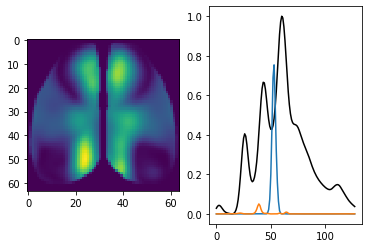

In [74]:
fig, ax = plt.subplots(1,2)
n_id = 0
id = np.array(slow_wave_ids)[where][n_id]
ax[0].imshow(dataset["sws"][id]["mean_sources"])
ax[1].plot(dataset["sws"][id]["gcamp_interpolated"], c="black")
ax[1].plot(up_in_time[n_id])
ax[1].plot(down_in_time[n_id])
print("See animation for " + id)

In [75]:
%%capture
data = np.einsum("ijk->jik", np.array([up_in_time, down_in_time, gcamp]))
anim = plot_animation(data, n_frames=200)

In [76]:
HTML(anim.to_jshtml())

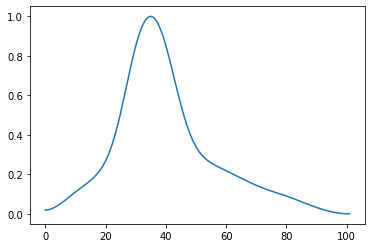

328
21.83685853293904


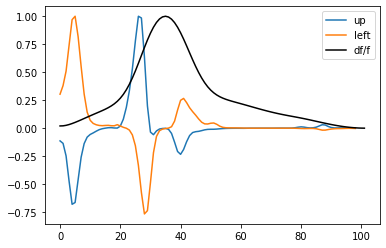

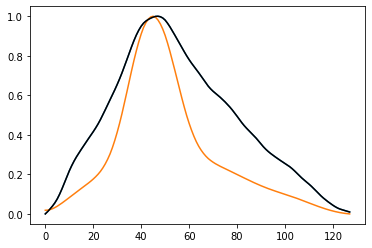

In [77]:
i = np.argwhere(where).flatten()[35]
plt.plot(dataset["sws"][slow_wave_ids[i]]["shape"])
plt.show()
print(i)
u, d, l, r = dataset["sws"][slow_wave_ids[i]]["flow_components"]["per_frame"]["left_hemisphere"]

ud = u-d
lr = l-r

ud = ud/np.nanmax([np.nanmax([ud]), -np.nanmin([ud])])
lr = lr/np.nanmax([np.nanmax([lr]), -np.nanmin([lr])])

fig, ax = plt.subplots()
#ax.plot(normalize(np.nanmean([u,d,l,r], axis=0)), c = "lightgray", label = "abs flow")
ax.plot(ud, label = "up")
ax.plot(lr, label = "left")
shape = dataset["sws"][slow_wave_ids[i]]["shape"]
print(dataset["sws"][slow_wave_ids[i]]["height"])
ax.plot(shape[~np.isnan(shape)], color = "black", label = "df/f")
ax.legend()

plt.show()
plt.plot(dataset["sws"][slow_wave_ids[i]]["gcamp_improved_interpolated"])
plt.plot(dataset["sws"][slow_wave_ids[i]]["gcamp_interpolated"])
plt.plot(normalize(dataset["sws"][slow_wave_ids[i]]["gcamp_improved_interpolated"]), color = "black")

Text(0, 0.5, 'Absolute frequency')

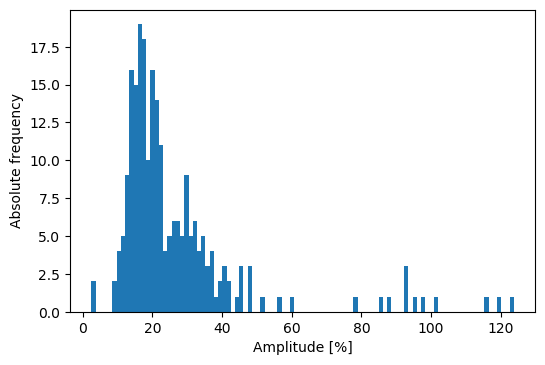

In [78]:
fig, ax = plt.subplots(1, dpi = 100)
_ = ax.hist(height, bins = 100)
ax.set_xlabel("Amplitude [%]")
ax.set_ylabel("Absolute frequency")

# Flow in a direction as percent of total flow

In [79]:
import pandas as pd
crosscorr = np.corrcoef([leftwards_by_tot, rightwards_by_tot, upwards_by_tot, downwards_by_tot])
df = pd.DataFrame(crosscorr, columns = ["Left","right", "up", "down"])
df.insert(0, column = "", value = ["Left","right", "up", "down"])
df

Left     right        up      down
0   Left  1.000000  0.617015 -0.111911 -0.724098
1  right  0.617015  1.000000 -0.129533 -0.717997
2     up -0.111911 -0.129533  1.000000 -0.484360
3   down -0.724098 -0.717997 -0.484360  1.000000

## Prepare data

Use train test split to split the dataset. 

Append features that we aim to plot later such that they are split and shuffled in the same way.

In [80]:
from sklearn.model_selection import train_test_split
random_state = 42
test_size=.1

In [81]:
data = np.expand_dims(data, -1)

In [82]:
data_train, data_test = train_test_split(data, test_size=test_size, random_state = random_state)

In [83]:
data_train.shape

(209, 3, 128, 1)

Save additional features as variables.

# Variational Autoenconder

In [84]:
## network parameters
from predictive_modeling.models.vae_cnn_signals_in_time import *
from keras import Model

batch_size = 100
epochs = 200

In [85]:
vectors_input, [z_mean, z_log_var, z] = encoder()
latent_inputs, values_decoded = decoder()

(None, 3, 128, 1)


In [86]:
encoder_model = Model(inputs = vectors_input, outputs = [z_mean, z_log_var, z])
decoder_model = Model(inputs = latent_inputs, outputs = values_decoded, name='decoder')

In [87]:
vectors_output = decoder_model(encoder_model(vectors_input)[2])

In [88]:
vae = Model(inputs = vectors_input, outputs = vectors_output, name='vae_mlp')

In [89]:
print("The input shapes of the autoencoder are: ")
print(vectors_input.shape)

The input shapes of the autoencoder are: 
(None, 3, 128, 1)


In [90]:
import keras
vae_loss = get_vae_loss(vectors_input, vectors_output, z_mean, z_log_var, impact_reconstruction_loss = 2)
#vae_loss = binary_crossentropy(vectors_input,vectors_output)
vae.add_loss(vae_loss)

vae.compile(optimizer= keras.optimizers.Adam(learning_rate=0.01))
vae.compile(optimizer = "adam")

/home/elerator/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [91]:
# train the autoencoder
history = vae.fit(data, epochs= 1000, batch_size=batch_size, verbose=2)

Epoch 1/1000
 - 4s - loss: 0.6630
Epoch 2/1000
 - 0s - loss: 0.4194
Epoch 3/1000
 - 0s - loss: 0.3572
Epoch 4/1000
 - 0s - loss: 0.3406
Epoch 5/1000
 - 0s - loss: 0.3288
Epoch 6/1000
 - 0s - loss: 0.3201
Epoch 7/1000
 - 0s - loss: 0.3140
Epoch 8/1000
 - 0s - loss: 0.3028
Epoch 9/1000
 - 0s - loss: 0.2936
Epoch 10/1000
 - 0s - loss: 0.2857
Epoch 11/1000
 - 0s - loss: 0.2794
Epoch 12/1000
 - 0s - loss: 0.2734
Epoch 13/1000
 - 0s - loss: 0.2694
Epoch 14/1000
 - 0s - loss: 0.2676
Epoch 15/1000
 - 0s - loss: 0.2652
Epoch 16/1000
 - 0s - loss: 0.2635
Epoch 17/1000
 - 0s - loss: 0.2620
Epoch 18/1000
 - 0s - loss: 0.2610
Epoch 19/1000
 - 0s - loss: 0.2598
Epoch 20/1000
 - 0s - loss: 0.2591
Epoch 21/1000
 - 0s - loss: 0.2583
Epoch 22/1000
 - 0s - loss: 0.2574
Epoch 23/1000
 - 0s - loss: 0.2567
Epoch 24/1000
 - 0s - loss: 0.2560
Epoch 25/1000
 - 0s - loss: 0.2551
Epoch 26/1000
 - 0s - loss: 0.2543
Epoch 27/1000
 - 0s - loss: 0.2536
Epoch 28/1000
 - 0s - loss: 0.2525
Epoch 29/1000
 - 0s - loss: 0

Epoch 232/1000
 - 0s - loss: 0.2221
Epoch 233/1000
 - 0s - loss: 0.2211
Epoch 234/1000
 - 0s - loss: 0.2208
Epoch 235/1000
 - 0s - loss: 0.2202
Epoch 236/1000
 - 0s - loss: 0.2200
Epoch 237/1000
 - 0s - loss: 0.2199
Epoch 238/1000
 - 0s - loss: 0.2197
Epoch 239/1000
 - 0s - loss: 0.2195
Epoch 240/1000
 - 0s - loss: 0.2194
Epoch 241/1000
 - 0s - loss: 0.2192
Epoch 242/1000
 - 0s - loss: 0.2194
Epoch 243/1000
 - 0s - loss: 0.2198
Epoch 244/1000
 - 0s - loss: 0.2197
Epoch 245/1000
 - 0s - loss: 0.2194
Epoch 246/1000
 - 0s - loss: 0.2191
Epoch 247/1000
 - 0s - loss: 0.2191
Epoch 248/1000
 - 0s - loss: 0.2192
Epoch 249/1000
 - 0s - loss: 0.2207
Epoch 250/1000
 - 0s - loss: 0.2219
Epoch 251/1000
 - 0s - loss: 0.2222
Epoch 252/1000
 - 0s - loss: 0.2215
Epoch 253/1000
 - 0s - loss: 0.2211
Epoch 254/1000
 - 0s - loss: 0.2203
Epoch 255/1000
 - 0s - loss: 0.2199
Epoch 256/1000
 - 0s - loss: 0.2195
Epoch 257/1000
 - 0s - loss: 0.2194
Epoch 258/1000
 - 0s - loss: 0.2191
Epoch 259/1000
 - 0s - loss:

Epoch 460/1000
 - 0s - loss: 0.2137
Epoch 461/1000
 - 0s - loss: 0.2136
Epoch 462/1000
 - 0s - loss: 0.2138
Epoch 463/1000
 - 0s - loss: 0.2138
Epoch 464/1000
 - 0s - loss: 0.2139
Epoch 465/1000
 - 0s - loss: 0.2270
Epoch 466/1000
 - 0s - loss: 0.2282
Epoch 467/1000
 - 0s - loss: 0.2282
Epoch 468/1000
 - 0s - loss: 0.2267
Epoch 469/1000
 - 0s - loss: 0.2230
Epoch 470/1000
 - 0s - loss: 0.2220
Epoch 471/1000
 - 0s - loss: 0.2198
Epoch 472/1000
 - 0s - loss: 0.2198
Epoch 473/1000
 - 0s - loss: 0.2186
Epoch 474/1000
 - 0s - loss: 0.2171
Epoch 475/1000
 - 0s - loss: 0.2174
Epoch 476/1000
 - 0s - loss: 0.2226
Epoch 477/1000
 - 0s - loss: 0.2274
Epoch 478/1000
 - 0s - loss: 0.2269
Epoch 479/1000
 - 0s - loss: 0.2251
Epoch 480/1000
 - 0s - loss: 0.2216
Epoch 481/1000
 - 0s - loss: 0.2195
Epoch 482/1000
 - 0s - loss: 0.2184
Epoch 483/1000
 - 0s - loss: 0.2185
Epoch 484/1000
 - 0s - loss: 0.2173
Epoch 485/1000
 - 0s - loss: 0.2174
Epoch 486/1000
 - 0s - loss: 0.2165
Epoch 487/1000
 - 0s - loss:

Epoch 688/1000
 - 0s - loss: 0.2106
Epoch 689/1000
 - 0s - loss: 0.2104
Epoch 690/1000
 - 0s - loss: 0.2105
Epoch 691/1000
 - 0s - loss: 0.2106
Epoch 692/1000
 - 0s - loss: 0.2110
Epoch 693/1000
 - 0s - loss: 0.2113
Epoch 694/1000
 - 0s - loss: 0.2113
Epoch 695/1000
 - 0s - loss: 0.2111
Epoch 696/1000
 - 0s - loss: 0.2109
Epoch 697/1000
 - 0s - loss: 0.2108
Epoch 698/1000
 - 0s - loss: 0.2107
Epoch 699/1000
 - 0s - loss: 0.2106
Epoch 700/1000
 - 0s - loss: 0.2105
Epoch 701/1000
 - 0s - loss: 0.2106
Epoch 702/1000
 - 0s - loss: 0.2105
Epoch 703/1000
 - 0s - loss: 0.2104
Epoch 704/1000
 - 0s - loss: 0.2104
Epoch 705/1000
 - 0s - loss: 0.2110
Epoch 706/1000
 - 0s - loss: 0.2130
Epoch 707/1000
 - 1s - loss: 0.2136
Epoch 708/1000
 - 0s - loss: 0.2130
Epoch 709/1000
 - 0s - loss: 0.2125
Epoch 710/1000
 - 1s - loss: 0.2120
Epoch 711/1000
 - 1s - loss: 0.2118
Epoch 712/1000
 - 0s - loss: 0.2116
Epoch 713/1000
 - 0s - loss: 0.2113
Epoch 714/1000
 - 0s - loss: 0.2112
Epoch 715/1000
 - 0s - loss:

Epoch 916/1000
 - 0s - loss: 0.2106
Epoch 917/1000
 - 0s - loss: 0.2108
Epoch 918/1000
 - 0s - loss: 0.2107
Epoch 919/1000
 - 0s - loss: 0.2108
Epoch 920/1000
 - 0s - loss: 0.2106
Epoch 921/1000
 - 0s - loss: 0.2106
Epoch 922/1000
 - 0s - loss: 0.2106
Epoch 923/1000
 - 0s - loss: 0.2105
Epoch 924/1000
 - 0s - loss: 0.2107
Epoch 925/1000
 - 0s - loss: 0.2107
Epoch 926/1000
 - 0s - loss: 0.2107
Epoch 927/1000
 - 0s - loss: 0.2106
Epoch 928/1000
 - 0s - loss: 0.2106
Epoch 929/1000
 - 0s - loss: 0.2105
Epoch 930/1000
 - 0s - loss: 0.2105
Epoch 931/1000
 - 0s - loss: 0.2106
Epoch 932/1000
 - 0s - loss: 0.2107
Epoch 933/1000
 - 0s - loss: 0.2106
Epoch 934/1000
 - 0s - loss: 0.2105
Epoch 935/1000
 - 0s - loss: 0.2105
Epoch 936/1000
 - 0s - loss: 0.2107
Epoch 937/1000
 - 0s - loss: 0.2105
Epoch 938/1000
 - 0s - loss: 0.2104
Epoch 939/1000
 - 0s - loss: 0.2104
Epoch 940/1000
 - 0s - loss: 0.2105
Epoch 941/1000
 - 0s - loss: 0.2103
Epoch 942/1000
 - 0s - loss: 0.2103
Epoch 943/1000
 - 0s - loss:

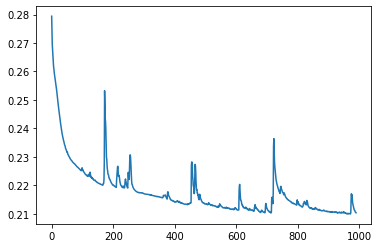

In [92]:
plt.plot(vae.history.history["loss"][10:])

# Visualize predictions

In [93]:
res = vae.predict(data)

In [94]:
latent_layer_activation = encoder_model.predict(data)[2]

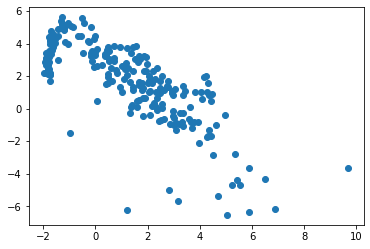

In [95]:
plt.scatter(latent_layer_activation[:,0], latent_layer_activation[:,1])

In [122]:
def manifold(decoder_model, n = 15, x_range = [-2,2], y_range = [-2, 6], figsize = (10,10), dpi = 500):
    predictions = np.ndarray((n,n), dtype = np.ndarray)
    
    for yi, y in enumerate(np.linspace(y_range[0], y_range[1], n)):
        for xi, x in enumerate(np.linspace(x_range[0], x_range[1], n)):
            predictions[yi,xi] = decoder_model.predict([[[y,x]]])[0,:,:,0].T
            
    fig, ax = plt.subplots(n, n, figsize= figsize, dpi = dpi)
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
    for y in range(predictions.shape[0]):
        for x in range(predictions.shape[1]):
            a = ax[y,x]
            a.axis("off")
            a.plot(np.fliplr(predictions[y,x]))
    return fig2rgb_array(fig)


In [123]:
%%capture
man = manifold(decoder_model)

Text(0, 0.5, 'z [1]')

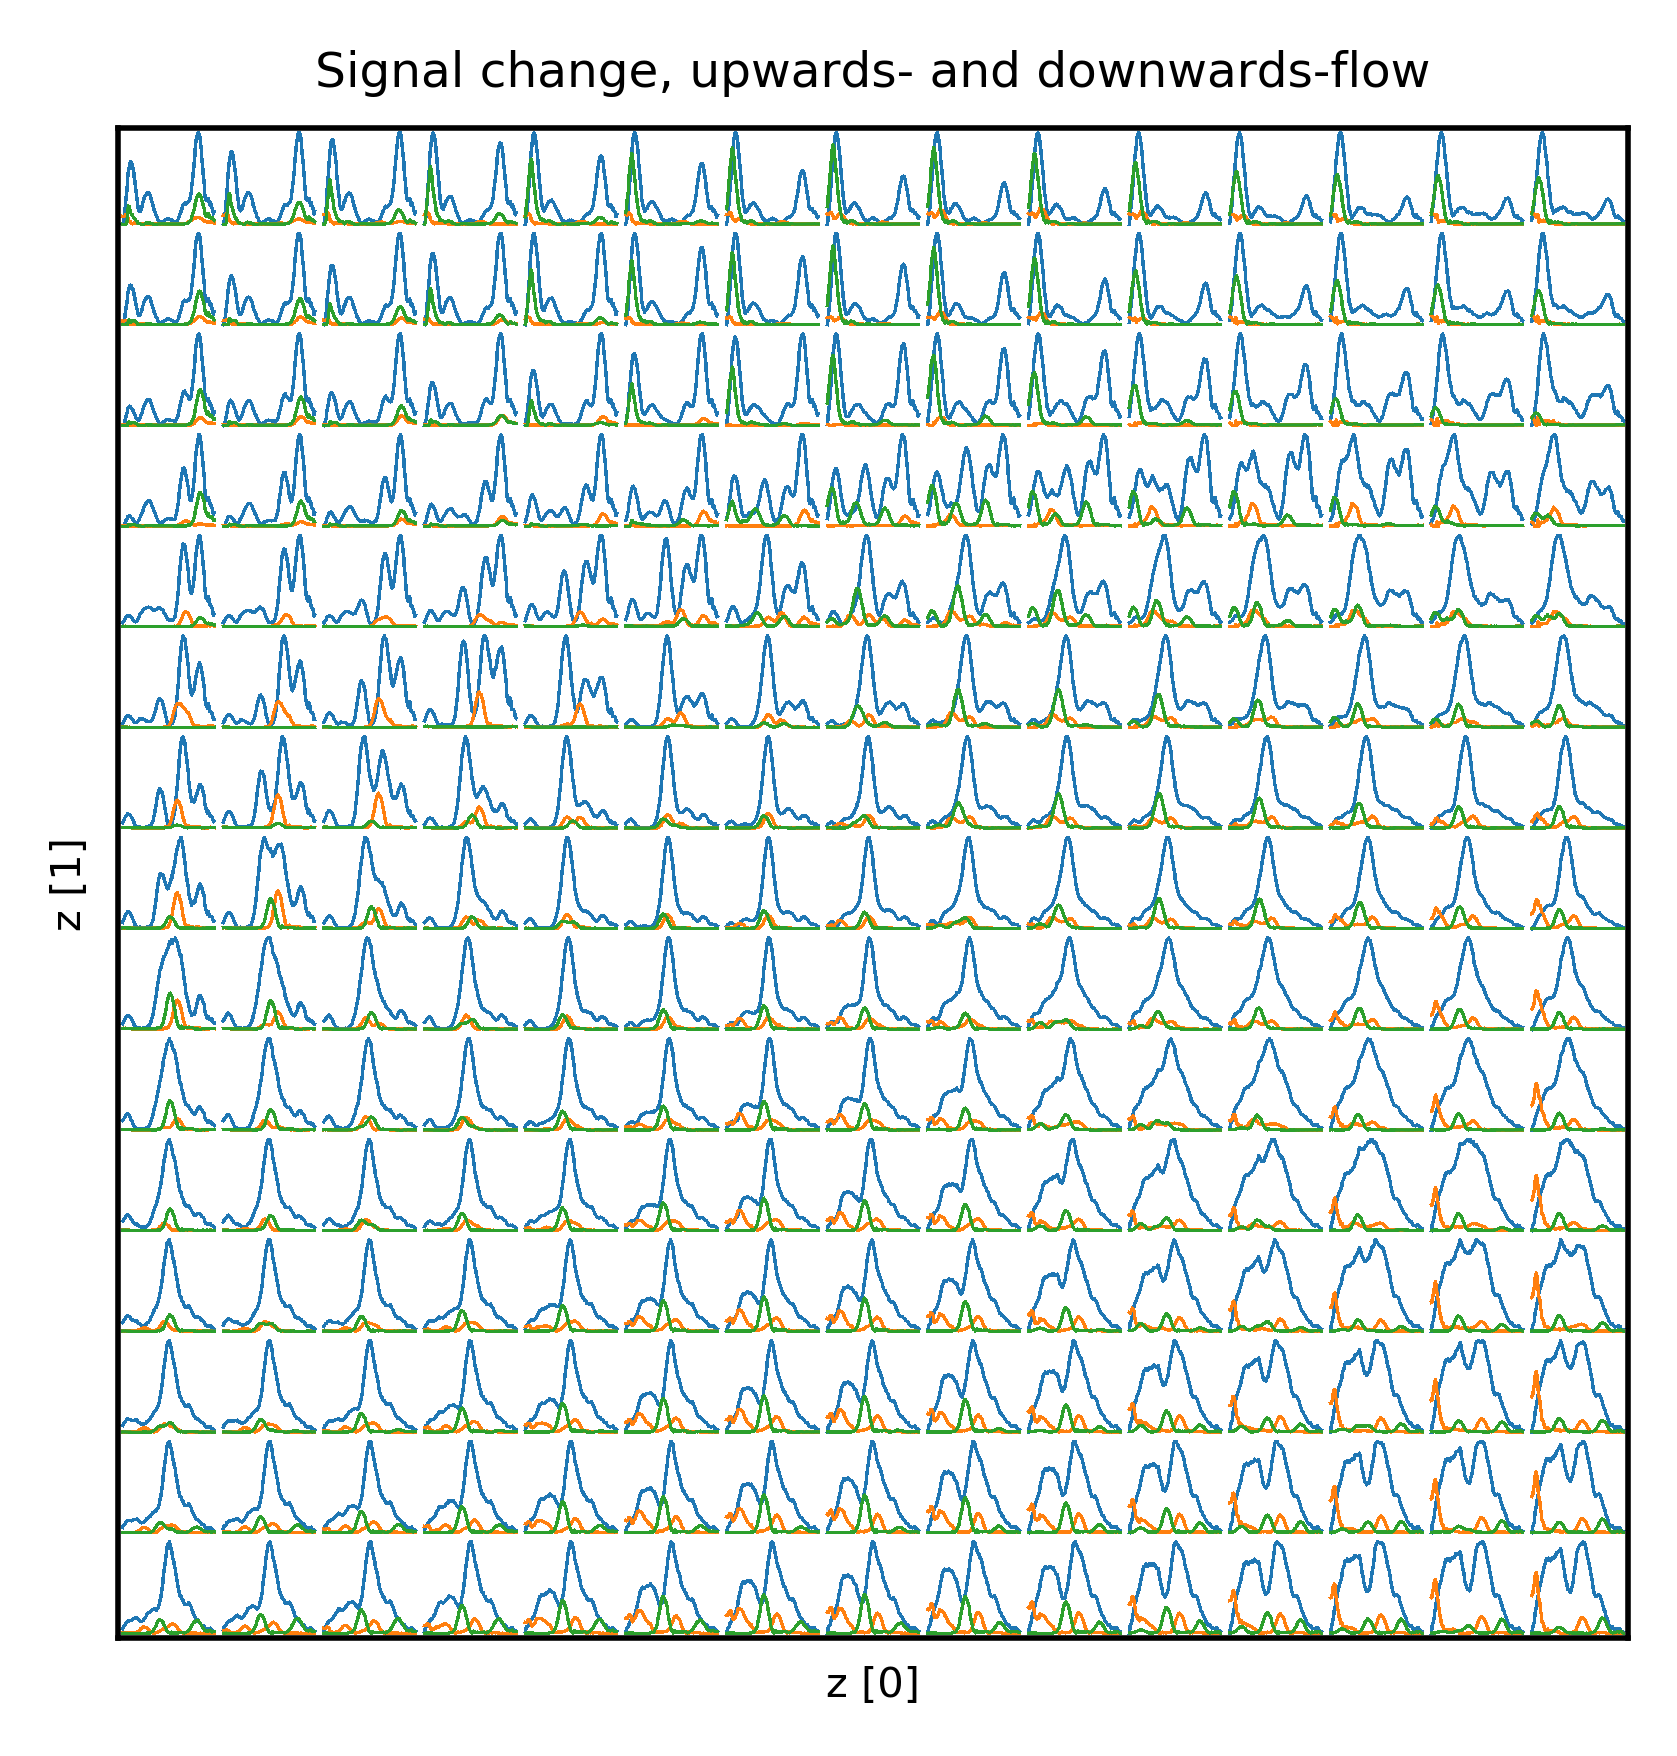

In [126]:
fig, ax = plt.subplots(1, dpi = 500)
ax.imshow(man)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Signal change, upwards- and downwards-flow", fontsize = 7)
ax.set_xlabel("z [0]", fontsize = 6)
ax.set_ylabel("z [1]", fontsize = 6)